# Facial Expression

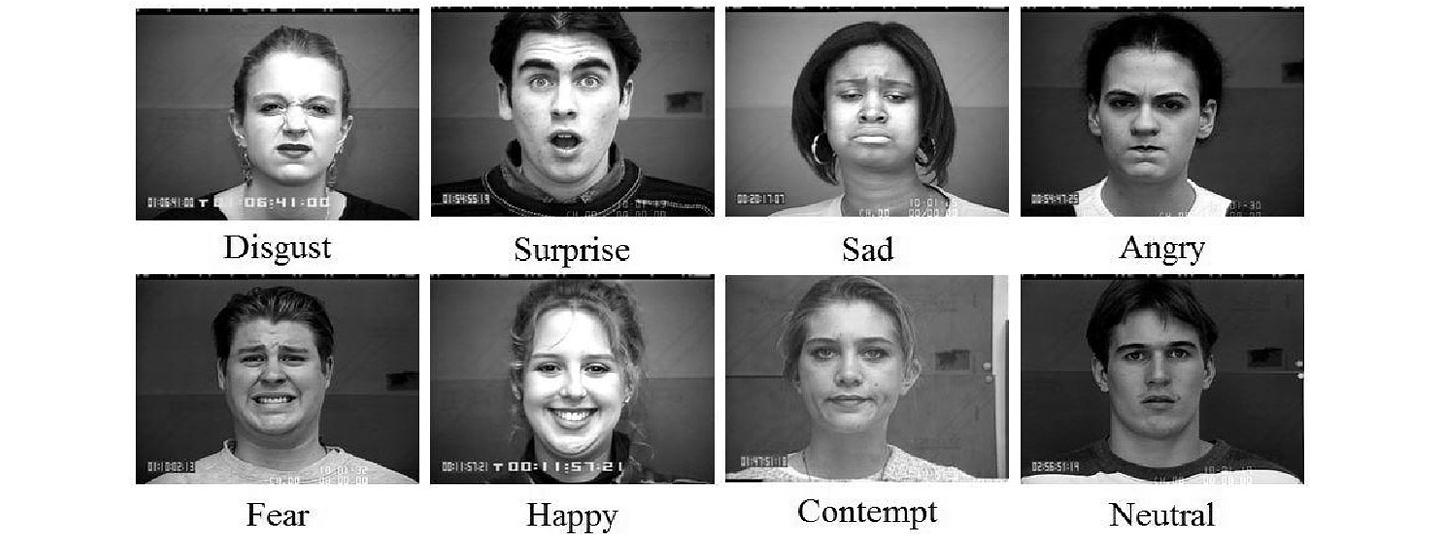

## Import Libraries 

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
from PIL import *

## Load the Data

In [2]:
facialexpression_df = pd.read_csv('../Data/icml_face_data.csv')

In [3]:
facialexpression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [4]:
facialexpression_df.shape

(24568, 2)

In [5]:
facialexpression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24568 entries, 0 to 24567
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24568 non-null  int64 
 1   pixels   24568 non-null  object
dtypes: int64(1), object(1)
memory usage: 384.0+ KB


In [6]:
facialexpression_df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [7]:
facialexpression_df['pixels'].shape

(24568,)

In [8]:
type(facialexpression_df['pixels'][0])

str

In [9]:
# function to convert pixel values in string format to array format

def str2arr(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [10]:
# Resize images from (48 ,48) to (96, 96)
import cv2 

def resize(x):
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96,96),interpolation=cv2.INTER_CUBIC)

In [11]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: str2arr(x))

In [12]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: resize(x))

In [13]:
facialexpression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [14]:
class_labels = ['anger', 'disgust', 'sad', 'happiness', 'surprise']

## Visualize Images

(96, 96)


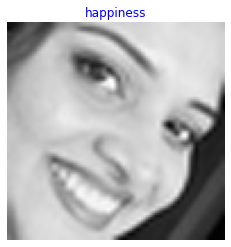

In [15]:
index = np.random.randint(1, len(facialexpression_df['pixels']))
print(facialexpression_df['pixels'][index].shape)
plt.imshow(facialexpression_df['pixels'][index], cmap="gray")
plt.title(class_labels[facialexpression_df['emotion'][index]], c='b')
plt.axis('off')
plt.show()

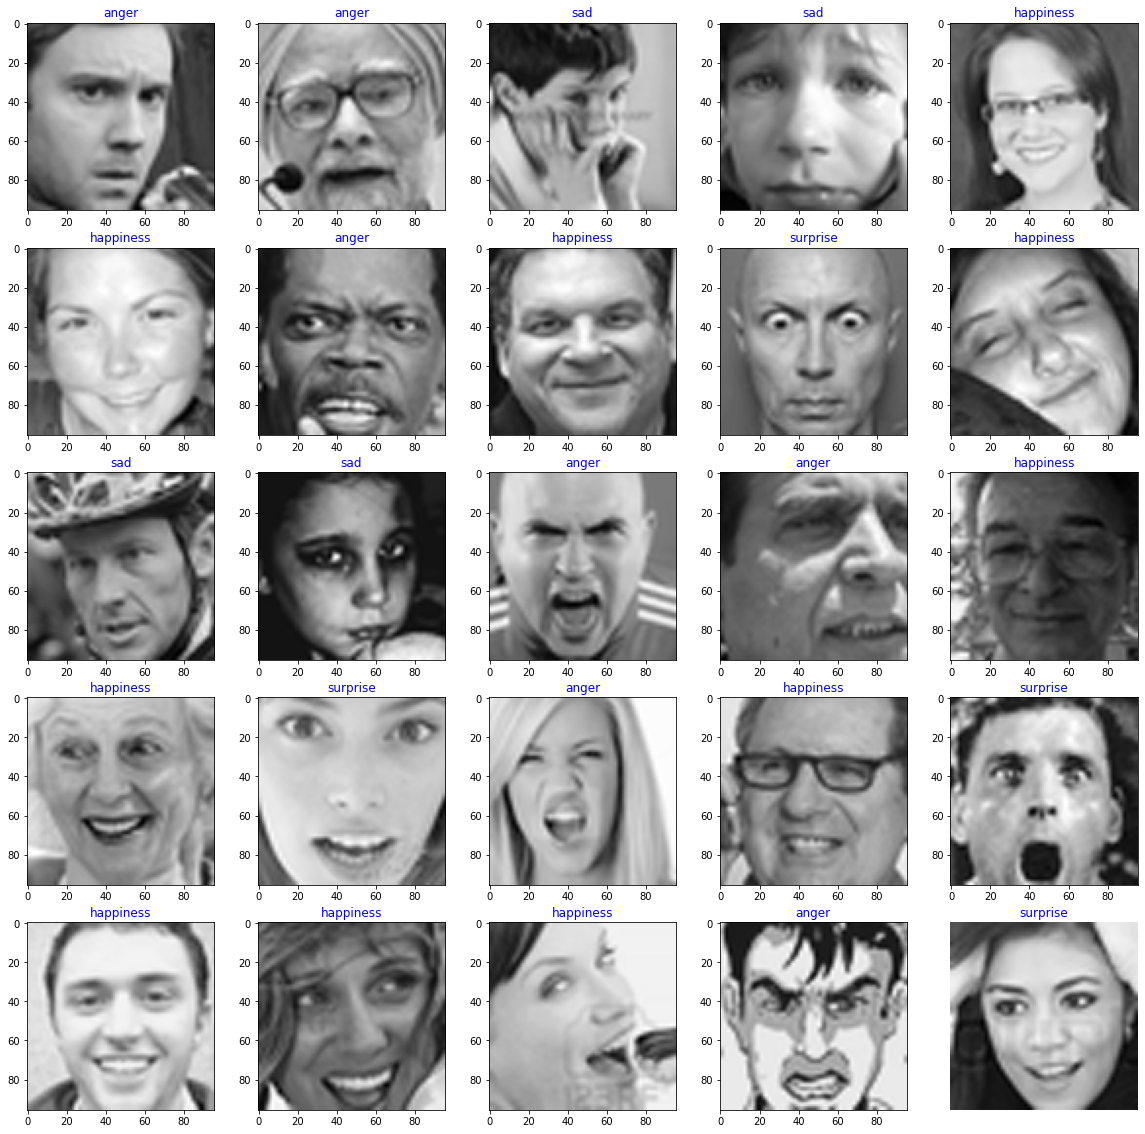

In [16]:
# Plot a grid of images
fig = plt.figure(figsize=(20,20))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    image = plt.imshow(facialexpression_df['pixels'][i], cmap="gray")
    plt.title(class_labels[facialexpression_df['emotion'][i]], c='b')
    
plt.axis('off')
plt.show()

In [17]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

['anger', 'disgust', 'sad', 'happiness', 'surprise']


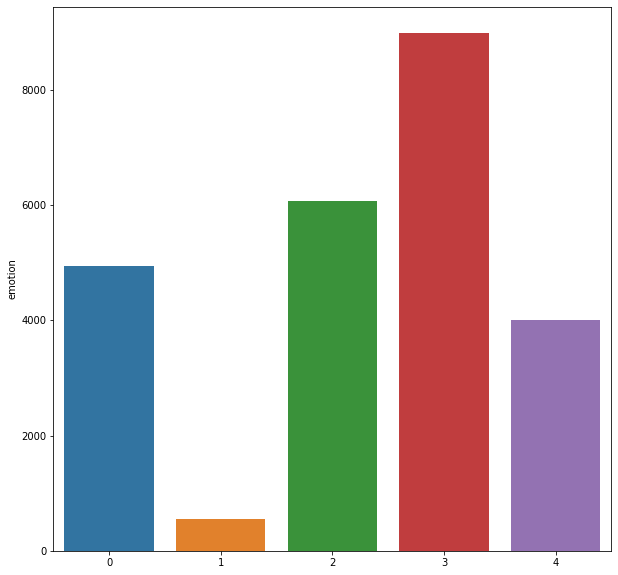

In [18]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.barplot(x=facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())
print(class_labels)

unbalanced data !

## Data Preparation and  Image Augmentation 

In [19]:
from tensorflow.keras.utils import to_categorical

X = facialexpression_df['pixels']
y = to_categorical(facialexpression_df['emotion'])

In [20]:
print(X.shape, y.shape)

(24568,) (24568, 5)


In [21]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [22]:
X[0].shape

(96, 96)

In [23]:
y[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [24]:
X = np.stack(X, axis=0)

In [25]:
X[0].shape

(96, 96)

In [26]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [27]:
X = X.reshape(24568, 96, 96, 1)
X.shape

(24568, 96, 96, 1)

In [28]:
X[0]

array([[[ 69.316925],
        [ 73.03865 ],
        [ 79.13719 ],
        ...,
        [ 40.73619 ],
        [ 40.6584  ],
        [ 40.5394  ]],

       [[ 68.66325 ],
        [ 70.95224 ],
        [ 74.71768 ],
        ...,
        [ 43.274765],
        [ 42.037186],
        [ 41.223618]],

       [[ 67.768814],
        [ 67.71646 ],
        [ 67.67172 ],
        ...,
        [ 47.39473 ],
        [ 44.26329 ],
        [ 42.31465 ]],

       ...,

       [[ 74.89021 ],
        [ 76.79553 ],
        [ 79.90259 ],
        ...,
        [ 71.463425],
        [ 59.32875 ],
        [ 51.74736 ]],

       [[ 76.68126 ],
        [ 75.808105],
        [ 74.25452 ],
        ...,
        [ 93.943375],
        [ 79.77934 ],
        [ 71.13246 ]],

       [[ 77.63858 ],
        [ 75.15074 ],
        [ 70.8846  ],
        ...,
        [107.66351 ],
        [ 92.23212 ],
        [ 82.91585 ]]], dtype=float32)

In [29]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(22111, 96, 96, 1) (22111, 5)
(1229, 96, 96, 1) (1229, 5)
(1228, 96, 96, 1) (1228, 5)


In [32]:
X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenerator_image = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range= [1.1, 1.5], 
    fill_mode='nearest',
    validation_split=0.2
)

datagenerator_image.fit(X_train)

## Build the model

In [34]:
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *

def res_block(X, filters, stage):
    # Convolutional_block
    X_copy = X

    f1 , f2, f3 = filters

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 
   
    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [35]:
input_shape = (96, 96, 1)
# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filters= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filters= [128,128,512], stage= 3)

# 4 - stage
X = res_block(X, filters= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name='Dense_final', kernel_initializer= glorot_uniform(seed = 0))(X)

model = Model( inputs= X_input, outputs = X, name='Resnet18')
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

## Train the model 

In [36]:
# train the network
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [37]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "../models/FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [44]:

history = model.fit(X_train,
                    y_train,
                    batch_size = 64,
                    epochs = 100,
                    validation_split = 0.1,
                    callbacks=[checkpointer, earlystopping])
                    
"""

epochs = 50

history = model.fit(datagenerator_image.flow(X_train, y_train, batch_size=64),
                              validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
                              epochs= epochs, callbacks=[checkpointer, earlystopping])
"""

Epoch 1/100
311/311 [==============================] - 140s 438ms/step - loss: 0.6752 - accuracy: 0.7409 - val_loss: 1.8084 - val_accuracy: 0.1922

Epoch 00001: val_loss did not improve from 1.53026
Epoch 2/100
311/311 [==============================] - 133s 427ms/step - loss: 0.5642 - accuracy: 0.7852 - val_loss: 1.5791 - val_accuracy: 0.2280

Epoch 00002: val_loss did not improve from 1.53026
Epoch 3/100
311/311 [==============================] - 133s 428ms/step - loss: 0.4780 - accuracy: 0.8201 - val_loss: 1.0300 - val_accuracy: 0.6059

Epoch 00003: val_loss improved from 1.53026 to 1.02996, saving model to ../models\FacialExpression_weights.hdf5


C:\Users\Khaliladib\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
311/311 [==============================] - 133s 427ms/step - loss: 0.4057 - accuracy: 0.8438 - val_loss: 0.7794 - val_accuracy: 0.7199

Epoch 00004: val_loss improved from 1.02996 to 0.77940, saving model to ../models\FacialExpression_weights.hdf5
Epoch 5/100
311/311 [==============================] - 133s 428ms/step - loss: 0.3410 - accuracy: 0.8695 - val_loss: 0.9746 - val_accuracy: 0.6694

Epoch 00005: val_loss did not improve from 0.77940
Epoch 6/100
311/311 [==============================] - 133s 427ms/step - loss: 0.2677 - accuracy: 0.8980 - val_loss: 0.8681 - val_accuracy: 0.7239

Epoch 00006: val_loss did not improve from 0.77940
Epoch 7/100
311/311 [==============================] - 133s 428ms/step - loss: 0.2191 - accuracy: 0.9156 - val_loss: 1.0187 - val_accuracy: 0.6914

Epoch 00007: val_loss did not improve from 0.77940
Epoch 8/100
311/311 [==============================] - 133s 428ms/step - loss: 0.1945 - accuracy: 0.9290 - val_loss: 1.1068 - val_accuracy: 0.7

'\n\nepochs = 50\n\nhistory = model.fit(datagenerator_image.flow(X_train, y_train, batch_size=64),\n                              validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,\n                              epochs= epochs, callbacks=[checkpointer, earlystopping])\n'

## Save the model

In [45]:
# saving the model architecture to json file for future use

model_json = model.to_json()
with open("../models/FacialExpression-model.json","w") as json_file:
    json_file.write(model_json)

## Check Model Performance

In [46]:
# Evaluate the model
result = model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

39/39 [==============================] - 3s 66ms/step - loss: 1.3865 - accuracy: 0.7242
Accuracy : 0.7241659760475159


In [47]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

In [48]:
predicted_classes

array([3, 4, 2, ..., 4, 0, 0], dtype=int64)

In [49]:
y_true = np.argmax(y_test, axis=-1)

In [50]:
y_true

array([3, 2, 2, ..., 4, 2, 0], dtype=int64)

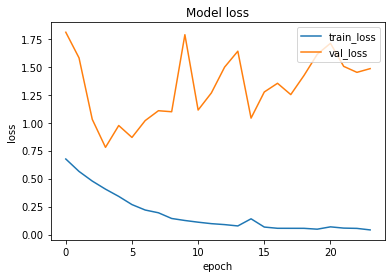

In [51]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

Overfitting

In [52]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

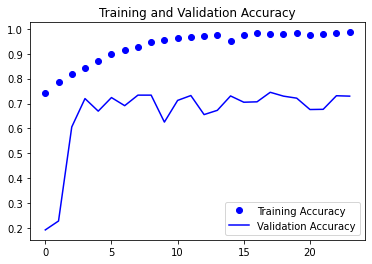

In [53]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

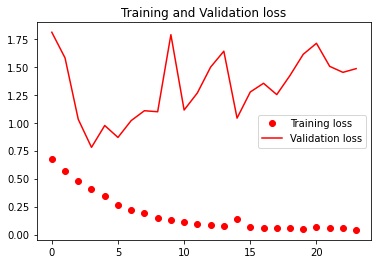

In [54]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [61]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

In [56]:
y_true.shape

(1229,)

<AxesSubplot:>

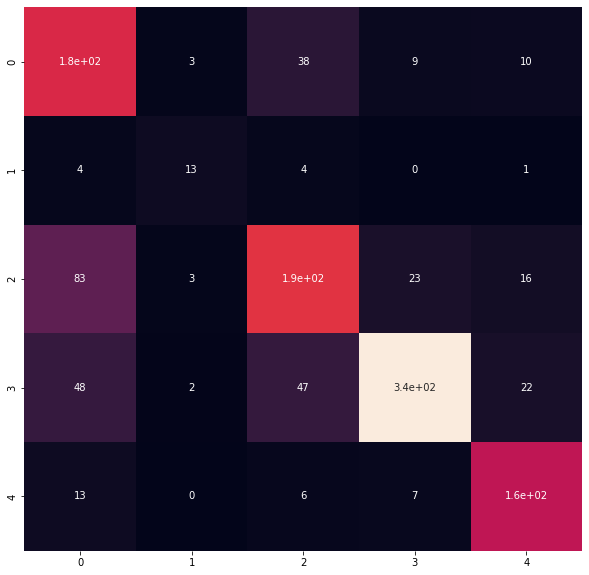

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

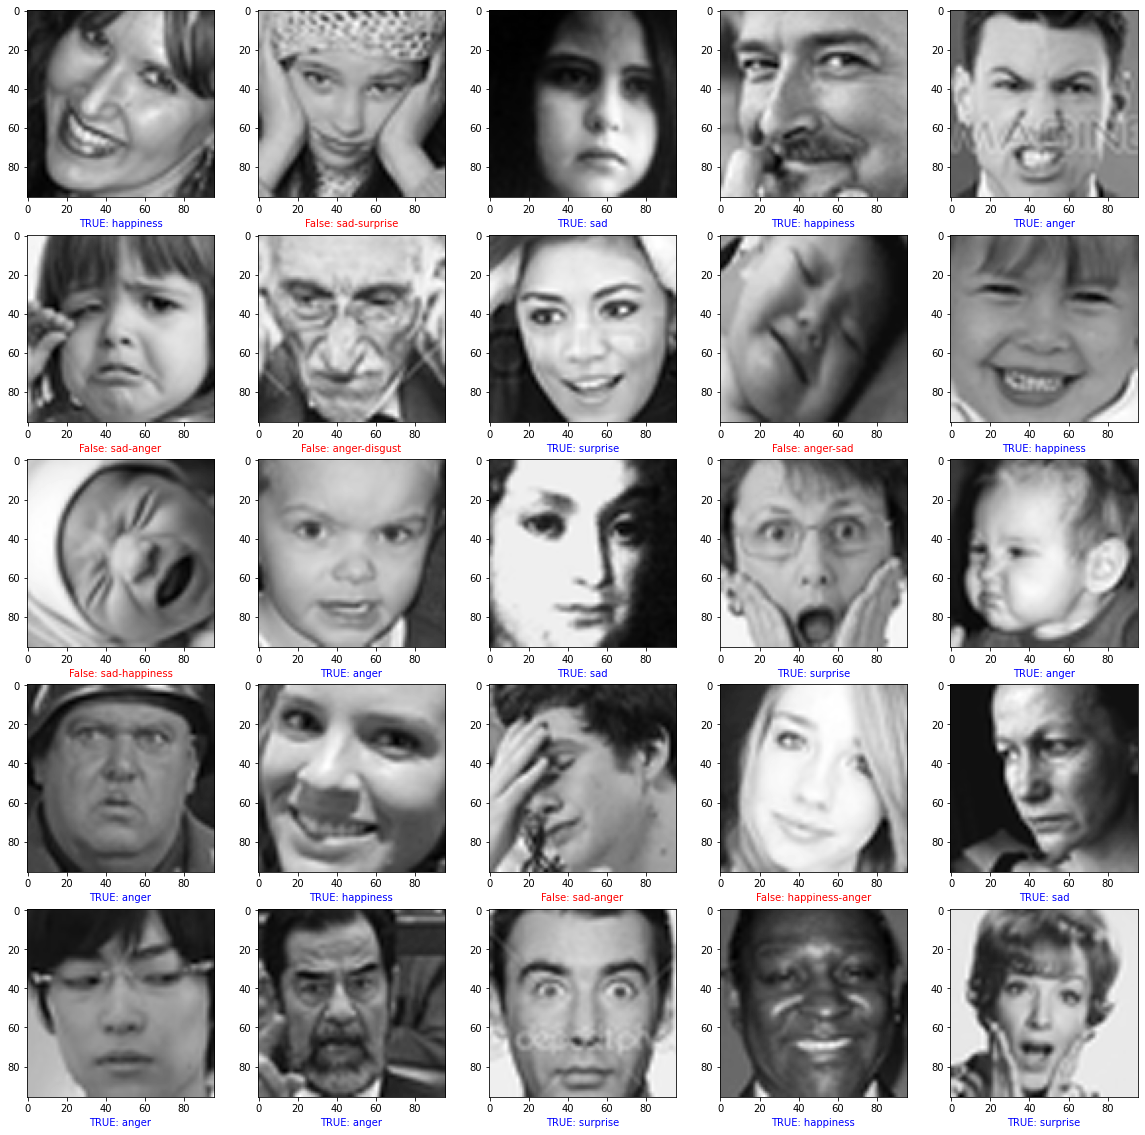

In [67]:
# Plot a grid of images
fig = plt.figure(figsize=(20,20))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    image = plt.imshow(X_test[i], cmap='gray')
    if y_true[i] == predicted_classes[i]: 
        plt.xlabel(f'TRUE: {class_labels[y_true[i]]}', c='b')
    else:
        plt.xlabel(f'False: {class_labels[y_true[i]]}-{class_labels[predicted_classes[i]]}', c='r')
